<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/tensorflow/CNN_Para_Reconhecimento_de_Imagens_com_CIFAR_10_Tensorflow_GPUTitan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Para Reconhecimento de Imagens com CIFAR-10

## Introdução

Veremos agora como construir uma Rede Neural Convolucional para classificar imagens no conjunto de dados CIFAR-10. 

https://www.cs.toronto.edu/~kriz/cifar.html

## Flowchart

O gráfico a seguir mostra aproximadamente como o fluxo de dados da Rede Neural Convolucional é implementado abaixo. Primeiro, a rede possui uma camada de pré-processamento que distorce as imagens de entrada de modo a inflar artificialmente o conjunto de treinamento. Em seguida, a rede possui duas camadas convolucionais, duas camadas totalmente conectadas e, finalmente, uma camada de classificação softmax. Os pesos e saídas das camadas convolucionais são mostrados com mais detalhes nos gráficos maiores abaixo.

![](https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/images/network_flowchart.png)

In [1]:
# Verifique se GPU tem memória disponível
!nvidia-smi

Tue Mar 26 08:52:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
#!pip install prettytensor
#!pip install tensorflow==1.0.1 # versão original do Titan = '1.10.1'
#!pip install tensorflow==1.0.1

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# O PrettyTensor simplifica a construção de Redes Neurais com TensorFlow
# https://github.com/google/prettytensor
import prettytensor as pt

Esse modelo foi desenvolvido usando a versão Python 3.6 (Anaconda) e TensorFlow:

In [6]:
tf.__version__

'1.0.1'

Versão do PrettyTensor:

In [7]:
pt.__version__

'0.7.4'

## Carregando os Dados

In [9]:
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cifar10.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cache.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/dataset.py
!wget https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/download.py

--2019-03-26 08:54:09--  https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2832 (2.8K) [text/plain]
Saving to: ‘cifar10.py’

cifar10.py          100%[===================>]   2.77K  --.-KB/s    in 0s      

2019-03-26 08:54:10 (74.6 MB/s) - ‘cifar10.py’ saved [2832/2832]

--2019-03-26 08:54:11--  https://raw.githubusercontent.com/vladimiralencar/DeepLearning-LANA/master/tensorflow/load_data/cifar10/cache.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting re

In [0]:
import cifar10

In [11]:
# O conjunto de dados CIFAR-10 é de cerca de 163 MB e será baixado automaticamente caso não seja encontrado.
cifar10.maybe_download_and_extract()

- Download em andamento: 100.0%
Download concluído. Extraindo os arquivos.
Feito.


In [0]:
class_names = cifar10.load_class_names()
class_names

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Carregando os dados: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [0]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Carregando os dados: data/CIFAR-10/cifar-10-batches-py/test_batch


In [0]:
print("- Dataset de Treino:\t\t{}".format(len(images_train)))
print("- Dataset de Teste:\t\t{}".format(len(images_test)))

- Dataset de Treino:		50000
- Dataset de Teste:		10000


In [0]:
from cifar10 import img_size, num_channels, num_classes

In [0]:
# As imagens são 32x32, mas iremos reduzir o tamanho para 24x24 a fim de dminuir o tempo de treinamento
img_size_cropped = 24

### Função Para Plot de Imagens

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        ax.imshow(images[i, :, :, :], interpolation=interpolation)
            
        cls_true_name = class_names[cls_true[i]]

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "Label Original: {0}\nPrevisão: {1}".format(cls_true_name, cls_pred_name)

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot de Algumas Imagens

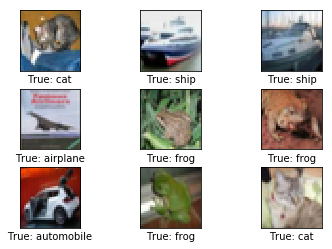

In [0]:
images = images_test[0:9]

cls_true = cls_test[0:9]

plot_images(images=images, cls_true=cls_true, smooth=False)

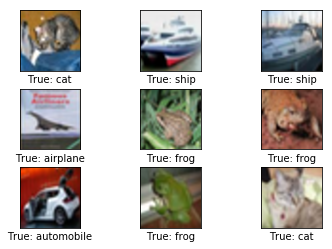

In [0]:
# As imagens pixeladas acima são o que a rede neural receberá como entrada. 
# As imagens podem ser um pouco mais fáceis para o olho humano reconhecer se "alisamos" os pixels.
plot_images(images=images, cls_true=cls_true, smooth=True)

## Criando o Grafo no TensorFlow 

### Placeholders

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [0]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Função Para Pré-Processamento dos Dados

In [0]:
def pre_process_image(image, training):
 
    if training:
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        image = tf.image.random_flip_left_right(image)
        
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

A função acima é chamada para cada imagem no lote de entrada usando a seguinte função.

In [0]:
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [0]:
distorted_images = pre_process(images=x, training=True)

### Função Para Definir a Rede Neural Convolucional

In [0]:
def main_network(images, training):
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    with pt.defaults_scope(activation_fn = tf.nn.relu, phase = phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel = 5, depth = 64, name = 'layer_conv1', batch_normalize = True).\
            max_pool(kernel = 2, stride = 2).\
            conv2d(kernel = 5, depth = 64, name = 'layer_conv2').\
            max_pool(kernel = 2, stride = 2).\
            flatten().\
            fully_connected(size = 256, name = 'layer_fc1').\
            fully_connected(size = 128, name = 'layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

### Função Para Criar a Rede Neural Convolucional

In [0]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        images = x

        images = pre_process(images=images, training=training)

        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Treinamento

Primeiro criamos uma variável TensorFlow que acompanha o número de iterações de otimização realizadas até o momento. 

Note que `trainable = False` o que significa que o TensorFlow não tentará otimizar esta variável.

In [0]:
global_step = tf.Variable(initial_value = 0, name = 'global_step', trainable = False)

In [0]:
_, loss = create_network(training=True)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Teste / Inferência

In [0]:
y_pred, _ = create_network(training=False)

In [0]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Salvando o Modelo

In [0]:
saver = tf.train.Saver()

### Obtendo os Pesos

Mais adiante, queremos plotar os pesos da rede neural. Quando a rede é construída usando o Pretty Tensor, todas as variáveis das camadas são criadas indiretamente pelo Pretty Tensor. Portanto, devemos recuperar as variáveis do TensorFlow.

Utilizamos os nomes `layer_conv1` e` layer_conv2` para as duas camadas convolucionais. Estes também são chamados escopos variáveis. Pretty Tensor automaticamente dá nomes às variáveis que cria para cada camada, para que possamos recuperar os pesos para uma camada usando o nome do escopo da camada e o nome da variável.

A implementação é um pouco incompreensível porque precisamos usar a função TensorFlow `get_variable ()` que foi projetada para outra finalidade; Criando uma nova variável ou reutilizando uma variável existente. O mais fácil é fazer a seguinte função auxiliar.

In [0]:
def get_weights_variable(layer_name):
    
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [0]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Obtendo os Outputs das Camadas

In [0]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Relu:0"

    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [0]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run

### Sessão TensorFlow

In [0]:
session = tf.Session()

### Restaurar ou inicializar variáveis

Treinar esta rede neural pode demorar muito tempo, especialmente se você não possui GPU. Portanto, incluímos pontos de controle durante o treinamento para que possamos continuar treinando em outro momento (por exemplo durante a noite), e também para realizar análises depois sem ter que treinar a rede neural sempre que quisermos usá-la.

Se você quiser reiniciar o treinamento da rede neural, você deve primeiro excluir os pontos de verificação.

Este é o diretório usado para os pontos de verificação.

In [0]:
save_dir = 'checkpoints/'

In [0]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [0]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [0]:
try:
    print("Tentando restaurar o último ponto de controle ...")

    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    saver.restore(session, save_path=last_chk_path)

    print("Ponto de verificação restaurado de:", last_chk_path)
except:
    print("Não foi possível restaurar o ponto de verificação. Inicializando variáveis em vez disso.")
    session.run(tf.global_variables_initializer())

Tentando restaurar o último ponto de controle ...
Não foi possível restaurar o ponto de verificação. Inicializando variáveis em vez disso.


### Função Para Gerar um training-batch

Há 50.000 imagens no conjunto de treinamento. Demora muito tempo calcular o gradiente do modelo usando todas essas imagens. Portanto, usamos apenas um pequeno lote de imagens em cada iteração do otimizador.

Se o seu computador falhar ou se tornar muito lento porque você está sem memória RAM, então você pode tentar diminuir esse número, mas talvez seja necessário executar mais iterações de otimização.

In [0]:
train_batch_size = 64

In [0]:
def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images, size=train_batch_size, replace=False)

    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Função Para Otimização

Esta função executa uma série de iterações de otimização para melhorar gradualmente as variáveis das camadas da rede. Em cada iteração, um novo lote de dados é selecionado a partir do conjunto de treinamento e, em seguida, TensorFlow executa o otimizador usando essas amostras de treinamento. O progresso é impresso a cada 100 iterações. Um ponto de verificação é salvo a cada 1000 iterações e também após a última iteração.

In [0]:
def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Acurácia no Training Batch: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session, save_path=save_path, global_step=global_step)

            print("Checkpoint Salvo.")

    end_time = time.time()

    time_dif = end_time - start_time

    print("Tempo gasto: " + str(timedelta(seconds=int(round(time_dif)))))

### Função Para Plot dos Erros

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)

    images = images_test[incorrect]

    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Função Para o Plot da Confusion Matrix

In [0]:
def plot_confusion_matrix(cls_pred):

    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)  

    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Função Para Calcular as Classificações

In [0]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [0]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Função Para Acurácia de Classificação

In [0]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Função Para Visualizar a Performance

In [0]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)

    msg = "Acurácia no Dataset de Teste: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    if show_example_errors:
        print("Errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Função Para Plot dos Pesos Convolucionais

In [0]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)

    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Função Para o Plot das Saídas das Camadas Convolucionais

In [0]:
def plot_layer_output(layer_output, image):
    feed_dict = {x: [image]}
    
    values = session.run(layer_output, feed_dict=feed_dict)

    values_min = np.min(values)
    values_max = np.max(values)

    num_images = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_images))

    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = values[0, :, :, i]

            ax.imshow(img, vmin=values_min, vmax=values_max, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

## Exemplos de Imagens de Input

In [0]:
def plot_distorted_image(image, cls_true):
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    feed_dict = {x: image_duplicates}
    
    result = session.run(distorted_images, feed_dict=feed_dict)

    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [0]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [0]:
img, cls = get_test_image(16)

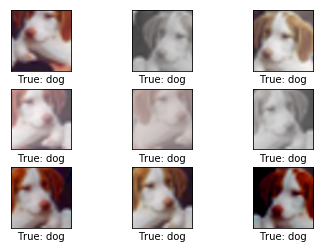

In [0]:
plot_distorted_image(img, cls)

## Otimização

Dependendo do número de otimizações, isso pode levar de 1 a 15 horas.

In [0]:
optimize(num_iterations = 120000) # Tempo gasto: 3:49:06

Global Step:    100, Acurácia no Training Batch:  25.0%
Global Step:    200, Acurácia no Training Batch:  37.5%
Global Step:    300, Acurácia no Training Batch:  40.6%
Global Step:    400, Acurácia no Training Batch:  32.8%
Global Step:    500, Acurácia no Training Batch:  45.3%
Global Step:    600, Acurácia no Training Batch:  42.2%
Global Step:    700, Acurácia no Training Batch:  31.2%
Global Step:    800, Acurácia no Training Batch:  48.4%
Global Step:    900, Acurácia no Training Batch:  50.0%
Global Step:   1000, Acurácia no Training Batch:  50.0%
Checkpoint Salvo.
Global Step:   1100, Acurácia no Training Batch:  48.4%
Global Step:   1200, Acurácia no Training Batch:  43.8%
Global Step:   1300, Acurácia no Training Batch:  43.8%
Global Step:   1400, Acurácia no Training Batch:  50.0%
Global Step:   1500, Acurácia no Training Batch:  48.4%
Global Step:   1600, Acurácia no Training Batch:  53.1%
Global Step:   1700, Acurácia no Training Batch:  42.2%
Global Step:   1800, Acurácia 

Global Step:  14300, Acurácia no Training Batch:  70.3%
Global Step:  14400, Acurácia no Training Batch:  70.3%
Global Step:  14500, Acurácia no Training Batch:  67.2%
Global Step:  14600, Acurácia no Training Batch:  67.2%
Global Step:  14700, Acurácia no Training Batch:  68.8%
Global Step:  14800, Acurácia no Training Batch:  59.4%
Global Step:  14900, Acurácia no Training Batch:  75.0%
Global Step:  15000, Acurácia no Training Batch:  65.6%
Checkpoint Salvo.
Global Step:  15100, Acurácia no Training Batch:  64.1%
Global Step:  15200, Acurácia no Training Batch:  71.9%
Global Step:  15300, Acurácia no Training Batch:  64.1%
Global Step:  15400, Acurácia no Training Batch:  62.5%
Global Step:  15500, Acurácia no Training Batch:  73.4%
Global Step:  15600, Acurácia no Training Batch:  67.2%
Global Step:  15700, Acurácia no Training Batch:  70.3%
Global Step:  15800, Acurácia no Training Batch:  70.3%
Global Step:  15900, Acurácia no Training Batch:  73.4%
Global Step:  16000, Acurácia 

Global Step:  28500, Acurácia no Training Batch:  82.8%
Global Step:  28600, Acurácia no Training Batch:  78.1%
Global Step:  28700, Acurácia no Training Batch:  73.4%
Global Step:  28800, Acurácia no Training Batch:  76.6%
Global Step:  28900, Acurácia no Training Batch:  81.2%
Global Step:  29000, Acurácia no Training Batch:  75.0%
Checkpoint Salvo.
Global Step:  29100, Acurácia no Training Batch:  71.9%
Global Step:  29200, Acurácia no Training Batch:  81.2%
Global Step:  29300, Acurácia no Training Batch:  78.1%
Global Step:  29400, Acurácia no Training Batch:  73.4%
Global Step:  29500, Acurácia no Training Batch:  73.4%
Global Step:  29600, Acurácia no Training Batch:  71.9%
Global Step:  29700, Acurácia no Training Batch:  75.0%
Global Step:  29800, Acurácia no Training Batch:  73.4%
Global Step:  29900, Acurácia no Training Batch:  70.3%
Global Step:  30000, Acurácia no Training Batch:  71.9%
Checkpoint Salvo.
Global Step:  30100, Acurácia no Training Batch:  68.8%
Global Step:

Global Step:  42700, Acurácia no Training Batch:  71.9%
Global Step:  42800, Acurácia no Training Batch:  76.6%
Global Step:  42900, Acurácia no Training Batch:  81.2%
Global Step:  43000, Acurácia no Training Batch:  79.7%
Checkpoint Salvo.
Global Step:  43100, Acurácia no Training Batch:  87.5%
Global Step:  43200, Acurácia no Training Batch:  76.6%
Global Step:  43300, Acurácia no Training Batch:  73.4%
Global Step:  43400, Acurácia no Training Batch:  84.4%
Global Step:  43500, Acurácia no Training Batch:  73.4%
Global Step:  43600, Acurácia no Training Batch:  75.0%
Global Step:  43700, Acurácia no Training Batch:  84.4%
Global Step:  43800, Acurácia no Training Batch:  87.5%
Global Step:  43900, Acurácia no Training Batch:  85.9%
Global Step:  44000, Acurácia no Training Batch:  71.9%
Checkpoint Salvo.
Global Step:  44100, Acurácia no Training Batch:  79.7%
Global Step:  44200, Acurácia no Training Batch:  75.0%
Global Step:  44300, Acurácia no Training Batch:  75.0%
Global Step:

Global Step:  56900, Acurácia no Training Batch:  85.9%
Global Step:  57000, Acurácia no Training Batch:  84.4%
Checkpoint Salvo.
Global Step:  57100, Acurácia no Training Batch:  90.6%
Global Step:  57200, Acurácia no Training Batch:  79.7%
Global Step:  57300, Acurácia no Training Batch:  68.8%
Global Step:  57400, Acurácia no Training Batch:  85.9%
Global Step:  57500, Acurácia no Training Batch:  70.3%
Global Step:  57600, Acurácia no Training Batch:  76.6%
Global Step:  57700, Acurácia no Training Batch:  82.8%
Global Step:  57800, Acurácia no Training Batch:  75.0%
Global Step:  57900, Acurácia no Training Batch:  89.1%
Global Step:  58000, Acurácia no Training Batch:  84.4%
Checkpoint Salvo.
Global Step:  58100, Acurácia no Training Batch:  85.9%
Global Step:  58200, Acurácia no Training Batch:  81.2%
Global Step:  58300, Acurácia no Training Batch:  92.2%
Global Step:  58400, Acurácia no Training Batch:  87.5%
Global Step:  58500, Acurácia no Training Batch:  90.6%
Global Step:

Global Step:  71100, Acurácia no Training Batch:  85.9%
Global Step:  71200, Acurácia no Training Batch:  75.0%
Global Step:  71300, Acurácia no Training Batch:  89.1%
Global Step:  71400, Acurácia no Training Batch:  92.2%
Global Step:  71500, Acurácia no Training Batch:  71.9%
Global Step:  71600, Acurácia no Training Batch:  78.1%
Global Step:  71700, Acurácia no Training Batch:  76.6%
Global Step:  71800, Acurácia no Training Batch:  87.5%
Global Step:  71900, Acurácia no Training Batch:  82.8%
Global Step:  72000, Acurácia no Training Batch:  85.9%
Checkpoint Salvo.
Global Step:  72100, Acurácia no Training Batch:  87.5%
Global Step:  72200, Acurácia no Training Batch:  84.4%
Global Step:  72300, Acurácia no Training Batch:  79.7%
Global Step:  72400, Acurácia no Training Batch:  82.8%
Global Step:  72500, Acurácia no Training Batch:  87.5%
Global Step:  72600, Acurácia no Training Batch:  79.7%
Global Step:  72700, Acurácia no Training Batch:  78.1%
Global Step:  72800, Acurácia 

Global Step:  85300, Acurácia no Training Batch:  81.2%
Global Step:  85400, Acurácia no Training Batch:  84.4%
Global Step:  85500, Acurácia no Training Batch:  84.4%
Global Step:  85600, Acurácia no Training Batch:  85.9%
Global Step:  85700, Acurácia no Training Batch:  81.2%
Global Step:  85800, Acurácia no Training Batch:  89.1%
Global Step:  85900, Acurácia no Training Batch:  79.7%
Global Step:  86000, Acurácia no Training Batch:  81.2%
Checkpoint Salvo.
Global Step:  86100, Acurácia no Training Batch:  81.2%
Global Step:  86200, Acurácia no Training Batch:  76.6%
Global Step:  86300, Acurácia no Training Batch:  87.5%
Global Step:  86400, Acurácia no Training Batch:  84.4%
Global Step:  86500, Acurácia no Training Batch:  89.1%
Global Step:  86600, Acurácia no Training Batch:  75.0%
Global Step:  86700, Acurácia no Training Batch:  82.8%
Global Step:  86800, Acurácia no Training Batch:  89.1%
Global Step:  86900, Acurácia no Training Batch:  79.7%
Global Step:  87000, Acurácia 

Global Step:  99500, Acurácia no Training Batch:  85.9%
Global Step:  99600, Acurácia no Training Batch:  78.1%
Global Step:  99700, Acurácia no Training Batch:  84.4%
Global Step:  99800, Acurácia no Training Batch:  85.9%
Global Step:  99900, Acurácia no Training Batch:  85.9%
Global Step: 100000, Acurácia no Training Batch:  89.1%
Checkpoint Salvo.
Global Step: 100100, Acurácia no Training Batch:  76.6%
Global Step: 100200, Acurácia no Training Batch:  85.9%
Global Step: 100300, Acurácia no Training Batch:  92.2%
Global Step: 100400, Acurácia no Training Batch:  82.8%
Global Step: 100500, Acurácia no Training Batch:  84.4%
Global Step: 100600, Acurácia no Training Batch:  84.4%
Global Step: 100700, Acurácia no Training Batch:  78.1%
Global Step: 100800, Acurácia no Training Batch:  82.8%
Global Step: 100900, Acurácia no Training Batch:  90.6%
Global Step: 101000, Acurácia no Training Batch:  81.2%
Checkpoint Salvo.
Global Step: 101100, Acurácia no Training Batch:  81.2%
Global Step:

Global Step: 113700, Acurácia no Training Batch:  79.7%
Global Step: 113800, Acurácia no Training Batch:  93.8%
Global Step: 113900, Acurácia no Training Batch:  82.8%
Global Step: 114000, Acurácia no Training Batch:  84.4%
Checkpoint Salvo.
Global Step: 114100, Acurácia no Training Batch:  87.5%
Global Step: 114200, Acurácia no Training Batch:  87.5%
Global Step: 114300, Acurácia no Training Batch:  84.4%
Global Step: 114400, Acurácia no Training Batch:  84.4%
Global Step: 114500, Acurácia no Training Batch:  87.5%
Global Step: 114600, Acurácia no Training Batch:  84.4%
Global Step: 114700, Acurácia no Training Batch:  78.1%
Global Step: 114800, Acurácia no Training Batch:  81.2%
Global Step: 114900, Acurácia no Training Batch:  90.6%
Global Step: 115000, Acurácia no Training Batch:  90.6%
Checkpoint Salvo.
Global Step: 115100, Acurácia no Training Batch:  89.1%
Global Step: 115200, Acurácia no Training Batch:  82.8%
Global Step: 115300, Acurácia no Training Batch:  87.5%
Global Step:

## Resultados

Após 120.000 iterações de otimização, a precisão da classificação é de cerca de 79-80% no conjunto de teste. Exemplos de classificações erradas são plotados abaixo. Alguns são difíceis de reconhecer, mesmo para os seres humanos e outros são erros razoáveis, p. Ex. Entre um grande carro e um caminhão, ou entre um gato e um cachorro, enquanto outros erros parecem um pouco estranhos.

Acurácia no Dataset de Teste: 80.2% (8023 / 10000)
Errors:


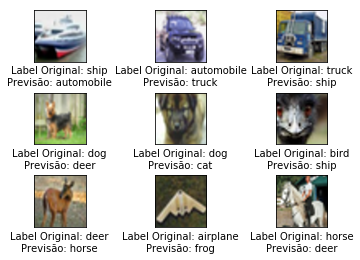

Confusion Matrix:
[834  15  41  14  12   9   7   6  40  22] (0) airplane
[  8 923   5  11   3   3   2   1  13  31] (1) automobile
[ 49   6 731  53  43  55  33  19   8   3] (2) bird
[ 22   7  41 633  31 166  46  32  13   9] (3) cat
[ 11   4  42  52 765  49  30  39   6   2] (4) deer
[  9   4  30 138  22 755   7  28   2   5] (5) dog
[  9   6  36  55  24  21 840   2   4   3] (6) frog
[ 15   4  17  38  36  61   8 812   2   7] (7) horse
[ 30  27  13  10   3   4   3   3 876  31] (8) ship
[ 17  61   6  11   1   8   5  12  25 854] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [0]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

### Pesos Convolucionais

O seguinte mostra alguns dos pesos (ou filtros) para a primeira camada convolucional. Existem 3 canais de entrada, portanto, há 3 desses conjuntos, que você pode plotar, alterando o `input_channel`.

Observe que os pesos positivos são vermelhos e os pesos negativos são azuis.

Min:  -0.65636, Max:   0.57375
Mean: -0.00110, Stdev: 0.16395


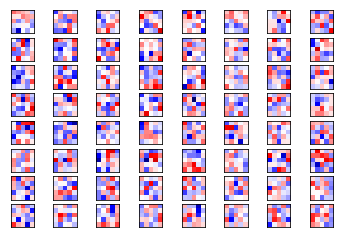

In [0]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.64997, Max:   0.30396
Mean: -0.00362, Stdev: 0.05154


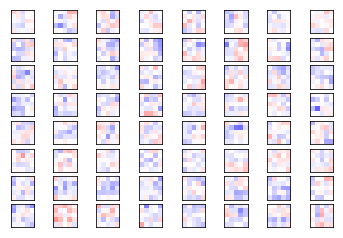

In [0]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output das Camadas de Convolução

In [0]:
def plot_image(image):
    fig, axes = plt.subplots(1, 2)

    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    plt.show()

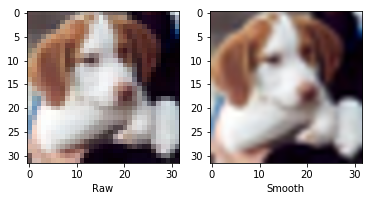

In [0]:
img, cls = get_test_image(16)
plot_image(img)

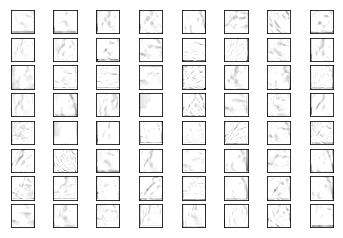

In [0]:
plot_layer_output(output_conv1, image=img)

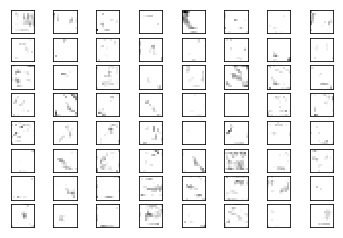

In [0]:
plot_layer_output(output_conv2, image=img)

### Labels de Classe Previstos

In [0]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

In [0]:
np.set_printoptions(precision=3, suppress=True)

print(label_pred[0])

[0.    0.    0.    0.063 0.    0.932 0.    0.004 0.    0.   ]


In [0]:
class_names[3]

'cat'

In [0]:
class_names[5]

'dog'

## Encerrando a Sessão

In [0]:
session.close()

## Conclusão

Este jupyter notebook mostrou como construir uma Rede Neural convolutiva para classificar imagens no conjunto de dados CIFAR-10. A precisão da classificação foi de cerca de 79-80% no conjunto de teste.